# Reading datasets

In [21]:
import pandas as pd
from collections import defaultdict 
import os, time, json
sample_data_filepath = './Sample Datasets/'
generated_data_filepath = './Generated Sample Datasets/'

### Select the datasets to use ###
data_filepath = generated_data_filepath

SSIC_TABLE = pd.read_csv(data_filepath + "pri_ssic.csv")
SHAREHOLDER_TABLE = pd.read_csv(data_filepath + "shareholders.csv")
APPOINTMENT_TABLE = pd.read_csv(data_filepath + "appointments.csv")
CORPPASS_TABLE = pd.read_csv(data_filepath + "corppass.csv")
ADDRESS_TABLE = pd.read_csv(data_filepath + "addresses.csv")

TABLE_NAMES_DICT = {"SSIC": SSIC_TABLE,
                    "Shareholder" : SHAREHOLDER_TABLE,
                    "Appointment" : APPOINTMENT_TABLE,
                    "CorpPass": CORPPASS_TABLE,
                    "Address": ADDRESS_TABLE}

RS_NAMES_DICT = {"SSIC": "Primary SSIC",
                    "Shareholder" : "Shareholder UEN",
                    "Appointment" : "Appointment Name",
                    "CorpPass": "CorpPass",
                    "Address": "Address"}


# Class Definitions

In [22]:
#################### WORKING WITH TUPLE ####################
# This class represents a directed graph 
# using adjacency list representation 

class Graph: 
    # Constructor 
    def __init__(self): 

        # default dictionary to store graph 
        self.graph = defaultdict(list) 
        self.immediateNeigh = defaultdict(set)

    # function to add an edge to graph only if node is not null
    def addEdge(self,u, v, rs): 
        bidir = False
        if str(u) != 'nan' and str(v) != 'nan':
            if bidir: # bidirectional
                self.graph[u].append((v, rs)) 
                self.graph[v].append((u, rs)) 
                self.immediateNeigh[u].add((v, rs))
                self.immediateNeigh[v].add((u, rs))
            else: # unidirectional
                self.graph[u].append((v, rs)) 
                self.immediateNeigh[u].add((v, rs))
        
    # Function to print a SSSP 
    def shortestPath(self, u, v): 
        
        # Mark all the vertices as not visited 
        visited = set()

        # Create a queue for BFS 
        queue = [] 

        # Mark the source node as 
        # visited and enqueue it 
        queue.append(u)
        visited.add(u)
        predecessor_dic = {}
        #predecessor of source is none
        predecessor_dic[u] = -1

        while queue: 
            # Dequeue a vertex from 
            # queue and print it 
            u = queue.pop(0) 

            # Get all adjacent vertices of the 
            # dequeued vertex s. If a adjacent 
            # has not been visited, then mark it 
            # visited and enqueue it 
            for i in self.immediateNeigh[u]: 
                i = i[0]
                if i not in visited: 
                    queue.append(i) 
                    visited.add(i)
                    predecessor_dic[i] = u
        if v in visited:
            #trace path
            return self.backtrack(v, predecessor_dic)
            
    def backtrack(self, v, predecessor_dic):
        if v == -1:
            return []
        tmp = self.backtrack(predecessor_dic[v], predecessor_dic)
        tmp.append(v)
        return tmp
#         return tmp + ' ' + v if tmp else v
            
    def depth(self, u, d, s={}): 
        #to find neighbours in depth of len(s) and less
        neighbours = self.immediateNeigh[u]
        visited = set()
        s = {} if s else s
        
        if u not in visited:
            
            if (d == 1) and neighbours:
                s[u] = neighbours

            elif neighbours:
                s[u] = set()
                for y in neighbours:
                    s[u].add(y)

                    for k,v in self.depth(y[0], d-1, s).items():
                        if not v:
                            continue

                        elif k in s.keys():
                            for item in v:
                                s[k].add(item)
                        else:
                            s[k] = set(v)
            visited.add(u)

        return s
    
    def filter(self, g, filter_dic):
        flag = 0
        
        #filtering process to those field that are wanted and add edges to graph
        if not all(value == [] for value in filter_dic.values()): # check if filter_dic values are not empty
            
            for colname, col_values in filter_dic.items(): # filter_dic example: {'Shareholder': ['sh1', 'sh2'], 'Appointment': ['app1']}
                df = TABLE_NAMES_DICT[colname]
                
                for col_value in col_values: # for each filtering value
                    filtered_df = df[df[RS_NAMES_DICT[colname]] == col_value] if colname.lower() != 'appointment' else df[df["Appointment Name"] == col_value]
                    
                    if not dict(filtered_df): # Checks if subset of table is empty and ignores it
                        continue 
                        
                    if colname.lower() != 'appointment':
                        filtered_df.apply(lambda x: g.addEdge(x["Entity UEN"], x[RS_NAMES_DICT[colname]], colname), axis=1)
                    else:
                        filtered_df.apply(lambda x: g.addEdge(x["Entity UEN"], x['Appointment UEN'], x[RS_NAMES_DICT[colname]]), axis=1)
                
        else: # if no filter is selected
            
            for colname in filter_dic.keys(): # filter_dic example: {'Shareholder': [], 'Appointment': []}
#                 print("Column Name: ", colname)                
                filtered_df = TABLE_NAMES_DICT[colname]
                
                if colname.lower() != 'appointment':
                    filtered_df.apply(lambda x: g.addEdge(x["Entity UEN"], x[RS_NAMES_DICT[colname]], colname), axis=1)
                else:
                    filtered_df.apply(lambda x: g.addEdge(x["Entity UEN"], x['Appointment UEN'], x[RS_NAMES_DICT[colname]]), axis=1)
        return g

# Runtime Measurements

In [23]:
class SetEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, set):
            return list(obj)
        return json.JSONEncoder.default(self, obj)

In [24]:
##MAIN                
# Create a graph given in 
# the above diagram

### Select the respective default values ###
num_iter = 30
depth = 10
node = 'en5' 

list_timings = []
for i in range(num_iter):
    start_depth = time.time()
    g = Graph() 
    g1 = g.filter(g, {'Shareholder' : [], 'Appointment': [], 'Address': [], 'SSIC': [], 'CorpPass': []}) ##key in the attributes to filter() to make the new graph
#     g1 = g.filter(g, {'Shareholder' : ['sh2'],'Appointment': ['Deputy Director'],'Address': ['add1'], 'SSIC': ['ssic1'], 'CorpPass': ['cp5']}) 
#     g1 = g.filter(g, {'Appointment': ['Deputy Director'], 'Shareholder' : []}) ##key in the attributes to filter() to make the new graph

    # Depth Search
    g1.depth(node, depth)
    end_depth = time.time()
    runtime = end_depth - start_depth
    list_timings.append(runtime)
print('Avg Depth Search runtime: ', sum(list_timings)/len(list_timings))
print(json.dumps(g1.depth(node, depth), cls=SetEncoder))

print('\n')

list_timings = []
g = Graph()
for i in range(num_iter):
    start_sp = time.time()
    
    g2 = g.filter(g, {'Shareholder' : [], 'Appointment': [], 'Address': [], 'SSIC': [], 'CorpPass': []}) ##key in the attributes to filter() to make the new graph
#     g2 = g.filter(g, {'Shareholder' : ['sh2'],'Appointment': ['Deputy Director'],'Address': ['add1'], 'SSIC': ['ssic1'], 'CorpPass': ['cp5']}) 
#     g2 = g.filter(g, {'Appointment': ['Deputy Director'], 'Shareholder' : []}) ##key in the attributes to filter() to make the new graph

    g2.shortestPath('en5', 'sh2') #'en6','sh2'
    end_sp = time.time()
    runtime = end_sp - start_sp
    list_timings.append(runtime)
print('Avg Shortest Path runtime: ', sum(list_timings)/len(list_timings))
print(g2.shortestPath('en5', 'sh2'))

Avg Depth Search runtime:  0.01870859464009603
{"en5": [["app5", "Deputy Director"], ["cp0", "CorpPass"], ["sh5", "Shareholder"], ["ssic5", "SSIC"], ["app4", "HR Manager"], ["app11", "HR Manager"], ["app1", "Sales Manager"], ["cp5", "CorpPass"], ["add5", "Address"]], "app5": [["app8", "HR Manager"]], "app8": [["app6", "Finance Manager"]], "app6": [["app11", "Project Lead"]], "app11": [["app7", "HR Manager"], ["en20", "Project Lead"], ["app4", "Sales Manager"]], "app7": [["app16", "HR Manager"]], "app16": [["en9", "HR Manager"]], "en9": [["sh9", "Shareholder"], ["app1", "Finance Manager"], ["app0", "HR Manager"], ["ssic20", "SSIC"], ["cp9", "CorpPass"], ["app9", "HR Manager"], ["app11", "Sales Manager"], ["app19", "Sales Manager"], ["ssic9", "SSIC"], ["add9", "Address"], ["ssic6", "SSIC"]], "app1": [["en18", "HR Manager"], ["app11", "Project Lead"]], "en18": [["ssic18", "SSIC"], ["sh18", "Shareholder"], ["app18", "Project Lead"], ["app11", "Project Lead"], ["cp18", "CorpPass"], ["add18"

# Plot of Network Graphs

In [75]:
import networkx as nx
import matplotlib.pyplot as plt

def generate_graph(set_of_nodes):
    G = nx.Graph()
    dict_of_nodes = dict(set_of_nodes)
#     dict_of_nodes = {'en1': ['sh1', 'sh2', 'sh3'],
#                     'en2': ['sh4', 'sh5']}
    
    for n, neighbours in dict_of_nodes.items():
        print(n)
        neighbours = list(neighbours)
        G.add_node(n)
        for idx in range(0, len(neighbours)):
            print (neighbours[idx], end = " ") 
            G.add_node(neighbours[idx])
            G.add_node(neighbours[idx])
            G.add_edge(n, neighbours[idx])
        print('\n')
        
    nx.draw_spectral(G, with_labels=True, node_size=1000)
    plt.show()

    return G

In [60]:
# g = Graph()
# g.filter(g, 'Shareholder', 'Appointment')
# G = generate_graph(g.depth('en5', 2, {}))
g_test = Graph()
g_test.filter(g_test, {'Shareholder' : [], 'Appointment': []})
G = g_test.depth('en5', 2, {})

AttributeError: 'dict' object has no attribute 'edges'

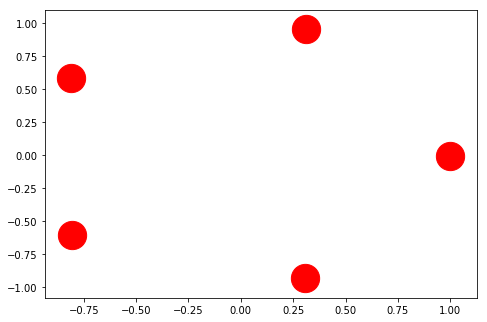

In [61]:
pos = nx.spring_layout(G, k=3,iterations=280)
nx.draw(G, pos, with_labels=True, node_size=800)

plt.show()